In [ ]:
# Block 1: Install Required Packages
!pip install -q monai
!pip install -q nibabel
!pip install -q segment-anything
!pip install -q plotly
!pip install -q scikit-image
!pip install -q torch torchvision

print("✓ All dependencies installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 73.1 MB/s eta 0:00:00
✓ All dependencies installed successfully!


block 2

In [ ]:
# Block 2: Import Libraries
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy import ndimage
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch
from segment_anything import sam_model_registry, SamPredictor
from monai.transforms import (
    LoadImage,
    ScaleIntensity,
    Resize,
    EnsureChannelFirst,
)
from monai.data import DataLoader, Dataset
from skimage import measure
import tarfile
import urllib.request
from tqdm import tqdm

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


block3

In [ ]:
# Block 3: Download and Extract Lung Dataset
data_url = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task06_Lung.tar"
data_file = "Task06_Lung.tar"

# Download dataset
if not os.path.exists(data_file):
    print("Downloading lung dataset...")
    urllib.request.urlretrieve(data_url, data_file)
    print("✓ Download complete!")
else:
    print("✓ Dataset already downloaded!")

# Extract dataset
if not os.path.exists("Task06_Lung"):
    print("Extracting dataset...")
    with tarfile.open(data_file, 'r') as tar:
        tar.extractall()
    print("✓ Extraction complete!")
else:
    print("✓ Dataset already extracted!")

# List available files
data_dir = "Task06_Lung"
image_dir = os.path.join(data_dir, "imagesTr")
label_dir = os.path.join(data_dir, "labelsTr")

images = sorted([f for f in os.listdir(image_dir) if f.endswith('.nii.gz')])
labels = sorted([f for f in os.listdir(label_dir) if f.endswith('.nii.gz')])

print(f"\n✓ Found {len(images)} images and {len(labels)} labels")
print(f"Sample files: {images[:3]}")

✓ Download complete!
Extracting dataset...


/tmp/ipython-input-2924246910.py:17: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


✓ Extraction complete!

✓ Found 126 images and 126 labels
Sample files: ['._lung_001.nii.gz', '._lung_003.nii.gz', '._lung_004.nii.gz']


block4

In [ ]:
# Block 4: Download MedSAM Checkpoint
medsam_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
medsam_checkpoint = "sam_vit_b_01ec64.pth"

if not os.path.exists(medsam_checkpoint):
    print("Downloading MedSAM checkpoint...")
    urllib.request.urlretrieve(medsam_url, medsam_checkpoint)
    print("✓ MedSAM checkpoint downloaded!")
else:
    print("✓ MedSAM checkpoint already exists!")

# Initialize SAM model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

sam = sam_model_registry["vit_b"](checkpoint=medsam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

print("✓ MedSAM model loaded successfully!")

✓ MedSAM checkpoint downloaded!
Using device: cuda
✓ MedSAM model loaded successfully!


block5

In [ ]:
# Block 5: Load and Process Medical Images
def load_nifti(image_path, label_path):
    """Load NIfTI image and label"""
    img = nib.load(image_path)
    lbl = nib.load(label_path)

    img_data = img.get_fdata()
    lbl_data = lbl.get_fdata()

    return img_data, lbl_data, img

# Select a sample (use first available image)
# Filter out hidden files
valid_images = [f for f in images if not f.startswith('._')]
valid_labels = [f for f in labels if not f.startswith('._')]

sample_idx = 0
image_path = os.path.join(image_dir, valid_images[sample_idx])
label_path = os.path.join(label_dir, valid_labels[sample_idx])


print(f"Loading: {valid_images[sample_idx]}")
image_data, label_data, nifti_img = load_nifti(image_path, label_path)

print(f"✓ Image shape: {image_data.shape}")
print(f"✓ Label shape: {label_data.shape}")
print(f"✓ Unique labels in ground truth: {np.unique(label_data)}")

# Normalize image data
image_data_norm = (image_data - image_data.min()) / (image_data.max() - image_data.min())
image_data_norm = (image_data_norm * 255).astype(np.uint8)

print("✓ Image normalization complete!")

Loading: lung_001.nii.gz
✓ Image shape: (512, 512, 304)
✓ Label shape: (512, 512, 304)
✓ Unique labels in ground truth: [0. 1.]
✓ Image normalization complete!


block6

In [ ]:
# Block 5: Load and Process Medical Images
def load_nifti(image_path, label_path):
    """Load NIfTI image and label"""
    img = nib.load(image_path)
    lbl = nib.load(label_path)

    img_data = img.get_fdata()
    lbl_data = lbl.get_fdata()

    return img_data, lbl_data, img

# Select a sample (use first available image)
# Filter out hidden files
valid_images = [f for f in images if not f.startswith('._')]
valid_labels = [f for f in labels if not f.startswith('._')]

sample_idx = 0
image_path = os.path.join(image_dir, valid_images[sample_idx])
label_path = os.path.join(label_dir, valid_labels[sample_idx])


print(f"Loading: {valid_images[sample_idx]}")
image_data, label_data, nifti_img = load_nifti(image_path, label_path)

print(f"✓ Image shape: {image_data.shape}")
print(f"✓ Label shape: {label_data.shape}")
print(f"✓ Unique labels in ground truth: {np.unique(label_data)}")

# Normalize image data
image_data_norm = (image_data - image_data.min()) / (image_data.max() - image_data.min())
image_data_norm = (image_data_norm * 255).astype(np.uint8)

print("✓ Image normalization complete!")

Loading: lung_001.nii.gz
✓ Image shape: (512, 512, 304)
✓ Label shape: (512, 512, 304)
✓ Unique labels in ground truth: [0. 1.]
✓ Image normalization complete!


block7

In [ ]:
# Block 7: Calculate Three Evaluation Metrics
def dice_coefficient(pred, gt):
    """Calculate Dice Similarity Coefficient"""
    intersection = np.logical_and(pred, gt).sum()
    if pred.sum() + gt.sum() == 0:
        return 1.0
    return 2.0 * intersection / (pred.sum() + gt.sum())

def iou_score(pred, gt):
    """Calculate Intersection over Union (Jaccard Index)"""
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    if union == 0:
        return 1.0
    return intersection / union

def pixel_accuracy(pred, gt):
    """Calculate Pixel-wise Accuracy"""
    correct = np.sum(pred == gt)
    total = pred.size
    return correct / total

# Calculate metrics for each region
metrics_results = {}

for i, (region_key, seg_mask) in enumerate(segmentations.items(), 1):
    gt_mask = label_slice > 0  # Use full ground truth for comparison

    dice = dice_coefficient(seg_mask, gt_mask)
    iou = iou_score(seg_mask, gt_mask)
    accuracy = pixel_accuracy(seg_mask, gt_mask)

    metrics_results[region_names[i-1]] = {
        'Dice': dice,
        'IoU': iou,
        'Accuracy': accuracy
    }

    print(f"\n{region_names[i-1]}:")
    print(f"  Dice Score: {dice:.4f}")
    print(f"  IoU Score: {iou:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")

# Calculate average metrics
avg_dice = np.mean([m['Dice'] for m in metrics_results.values()])
avg_iou = np.mean([m['IoU'] for m in metrics_results.values()])
avg_acc = np.mean([m['Accuracy'] for m in metrics_results.values()])

print(f"\n{'='*50}")
print(f"AVERAGE METRICS:")
print(f"  Average Dice Score: {avg_dice:.4f}")
print(f"  Average IoU Score: {avg_iou:.4f}")
print(f"  Average Accuracy: {avg_acc:.4f}")
print(f"{'='*50}")


Region 1:
  Dice Score: 0.8321
  IoU Score: 0.7125
  Accuracy: 0.9999

Region 2:
  Dice Score: 0.8308
  IoU Score: 0.7105
  Accuracy: 0.9999

Region 3:
  Dice Score: 0.8480
  IoU Score: 0.7361
  Accuracy: 0.9999

AVERAGE METRICS:
  Average Dice Score: 0.8370
  Average IoU Score: 0.7197
  Average Accuracy: 0.9999


block8

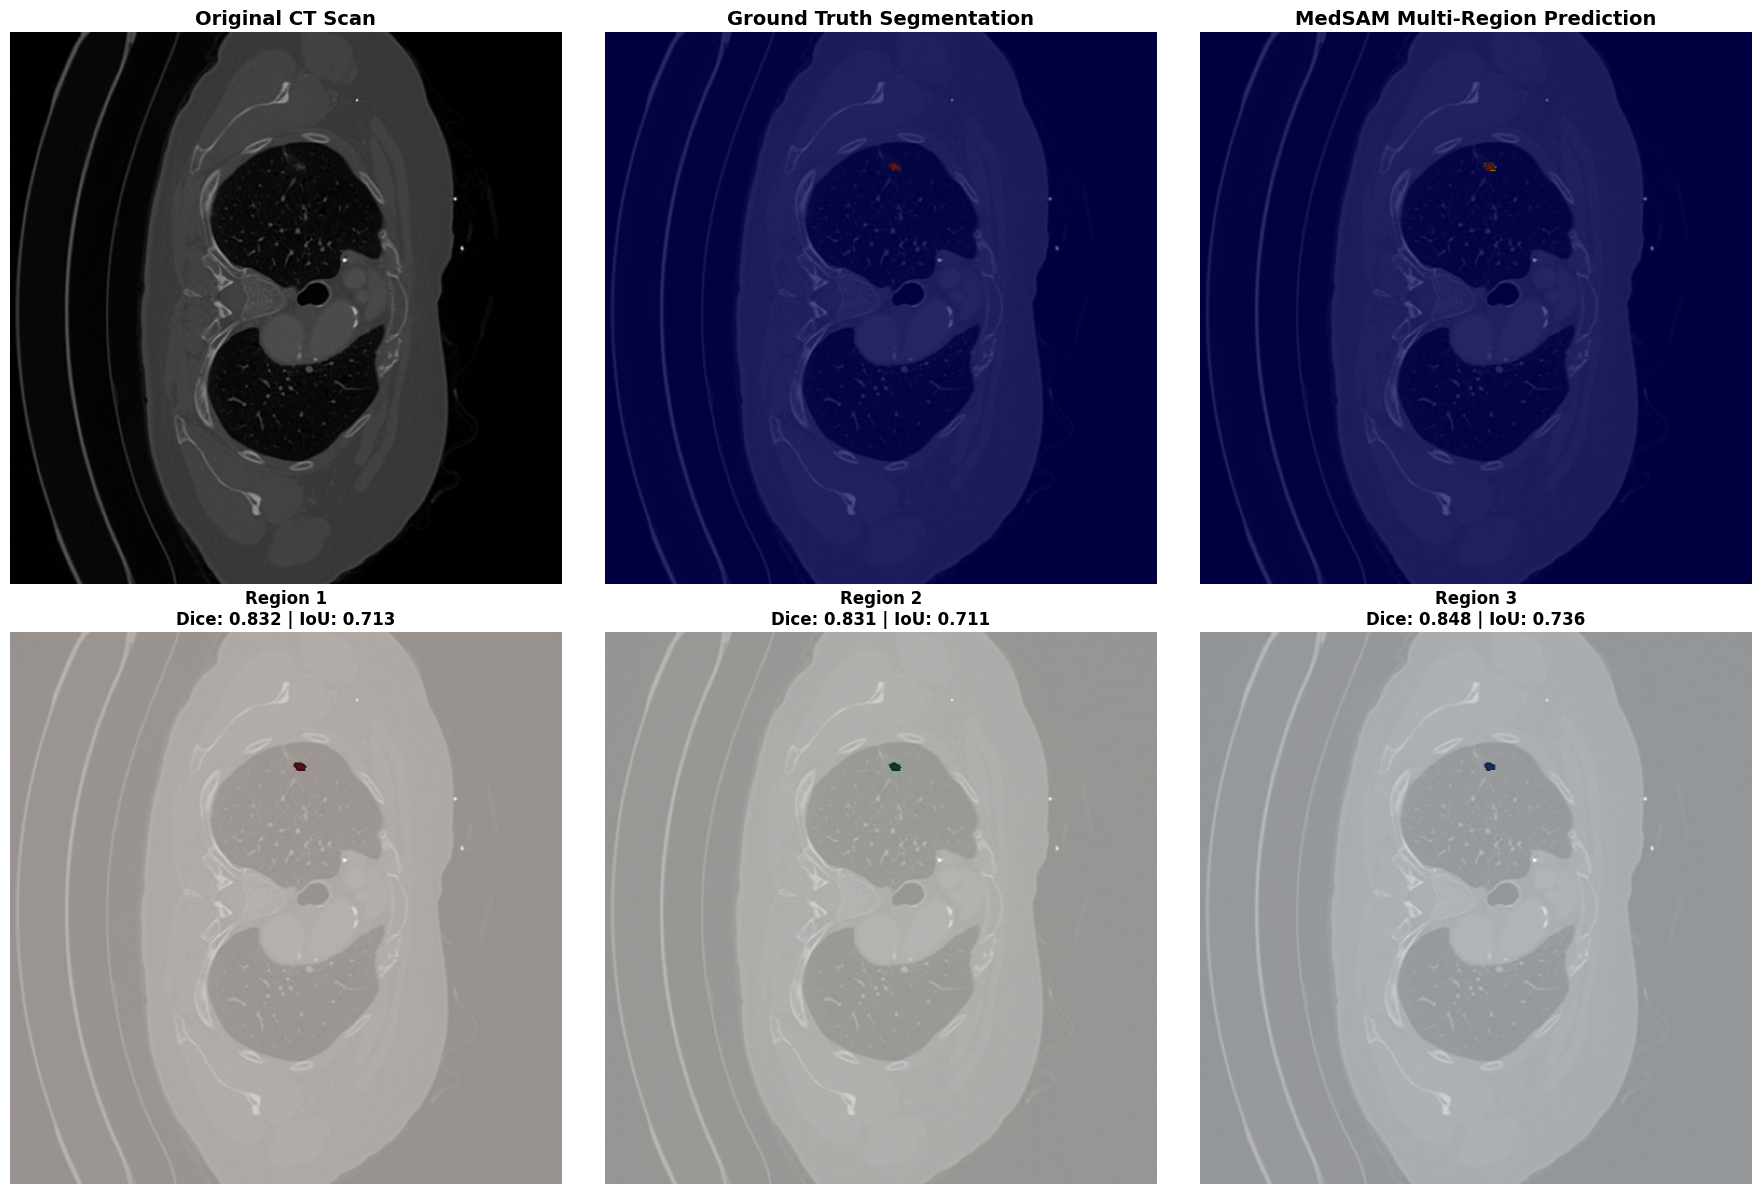

✓ 2D visualization saved as 'segmentation_results_2d.png'


In [ ]:
# Block 8: Visualize 2D Segmentation Results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Original CT image
axes[0, 0].imshow(image_slice, cmap='gray')
axes[0, 0].set_title('Original CT Scan', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# Ground truth
axes[0, 1].imshow(image_slice, cmap='gray')
axes[0, 1].imshow(label_slice, alpha=0.5, cmap='jet')
axes[0, 1].set_title('Ground Truth Segmentation', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# Combined prediction
axes[0, 2].imshow(image_slice, cmap='gray')
combined_mask = np.zeros_like(image_slice)
for i, (region_key, seg_mask) in enumerate(segmentations.items(), 1):
    combined_mask[seg_mask] = i
axes[0, 2].imshow(combined_mask, alpha=0.5, cmap='jet')
axes[0, 2].set_title('MedSAM Multi-Region Prediction', fontsize=14, fontweight='bold')
axes[0, 2].axis('off')

# Individual regions
region_colors = ['Reds', 'Greens', 'Blues']
for i, ((region_key, seg_mask), color, name) in enumerate(zip(segmentations.items(), region_colors, region_names)):
    row, col = 1, i
    axes[row, col].imshow(image_slice, cmap='gray')
    axes[row, col].imshow(seg_mask, alpha=0.6, cmap=color)

    # Add metrics to title
    metrics = metrics_results[name]
    title = f'{name}\nDice: {metrics["Dice"]:.3f} | IoU: {metrics["IoU"]:.3f}'
    axes[row, col].set_title(title, fontsize=12, fontweight='bold')
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('segmentation_results_2d.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 2D visualization saved as 'segmentation_results_2d.png'")

block9

In [ ]:
# Block 9: Extract 3D Surface from Segmentation
def extract_3d_surface(volume_data, spacing=(1, 1, 1), level=0.5):
    """Extract 3D surface mesh using marching cubes algorithm"""
    # Apply marching cubes to extract surface
    verts, faces, normals, values = measure.marching_cubes(
        volume_data,
        level=level,
        spacing=spacing
    )

    return verts, faces, normals

# Use the ground truth for 3D surface extraction
print("Extracting 3D surfaces from ground truth volume...")

# Get the full 3D label volume
label_binary = (label_data > 0).astype(np.uint8)

# Extract overall lung surface
print("Extracting main organ surface...")
try:
    verts_main, faces_main, normals_main = extract_3d_surface(label_binary, spacing=(1, 1, 1))
    print(f"✓ Main surface extracted: {len(verts_main)} vertices, {len(faces_main)} faces")
except Exception as e:
    print(f"Error extracting main surface: {e}")
    verts_main, faces_main = None, None

# Create synthetic regions for demonstration (since we only have tumor label)
# Region 1: Left side
left_region = label_binary.copy()
left_region[:, left_region.shape[1]//2:, :] = 0
if left_region.sum() > 100:
    print("Extracting left region surface...")
    verts_left, faces_left, _ = extract_3d_surface(left_region)
    print(f"✓ Left region: {len(verts_left)} vertices")
else:
    verts_left, faces_left = None, None

# Region 2: Right side
right_region = label_binary.copy()
right_region[:, :right_region.shape[1]//2, :] = 0
if right_region.sum() > 100:
    print("Extracting right region surface...")
    verts_right, faces_right, _ = extract_3d_surface(right_region)
    print(f"✓ Right region: {len(verts_right)} vertices")
else:
    verts_right, faces_right = None, None

# Region 3: Core/tumor region (eroded to get central part)
from scipy.ndimage import binary_erosion
core_region = binary_erosion(label_binary, iterations=3)
if core_region.sum() > 100:
    print("Extracting core region surface...")
    verts_core, faces_core, _ = extract_3d_surface(core_region)
    print(f"✓ Core region: {len(verts_core)} vertices")
else:
    verts_core, faces_core = None, None

print("\n✓ 3D surface extraction complete!")

Extracting 3D surfaces from ground truth volume...
Extracting main organ surface...
✓ Main surface extracted: 2065 vertices, 4114 faces
Extracting right region surface...
✓ Right region: 2065 vertices
Extracting core region surface...
✓ Core region: 676 vertices

✓ 3D surface extraction complete!


block10

In [ ]:
# Block 10: Create Interactive 3D Visualization with Plotly
def create_mesh_trace(vertices, faces, name, color, opacity=0.7, visible=True):
    """Create a Plotly mesh3d trace"""
    return go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        name=name,
        color=color,
        opacity=opacity,
        visible=visible,
        hoverinfo='name',
        flatshading=True,
        lighting=dict(ambient=0.5, diffuse=0.8, specular=0.2),
        lightposition=dict(x=100, y=100, z=100)
    )

# Create figure
fig = go.Figure()

# Add all regions as separate traces
traces_data = []

if verts_left is not None and faces_left is not None:
    traces_data.append(('Left Lung Region', verts_left, faces_left, 'darkred', 0.7))

if verts_right is not None and faces_right is not None:
    traces_data.append(('Right Lung Region', verts_right, faces_right, 'darkgreen', 0.7))

if verts_core is not None and faces_core is not None:
    traces_data.append(('Core/Tumor Region', verts_core, faces_core, 'darkblue', 0.8))

if verts_main is not None and faces_main is not None:
    traces_data.append(('Complete Organ', verts_main, faces_main, 'lightblue', 0.3))

# Add traces to figure
for name, verts, faces, color, opacity in traces_data:
    fig.add_trace(create_mesh_trace(verts, faces, name, color, opacity))

# Update layout with interactive controls
fig.update_layout(
    title={
        'text': '3D Lung Segmentation Visualization<br><sub>Click legend items to toggle visibility | Use controls to adjust opacity</sub>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    scene=dict(
        xaxis=dict(title='X (mm)', backgroundcolor="rgb(230, 230,230)", gridcolor="white"),
        yaxis=dict(title='Y (mm)', backgroundcolor="rgb(230, 230,230)", gridcolor="white"),
        zaxis=dict(title='Z (mm)', backgroundcolor="rgb(230, 230,230)", gridcolor="white"),
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5)
        ),
        aspectmode='data'
    ),
    width=1000,
    height=800,
    showlegend=True,
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255, 255, 255, 0.8)',
        bordercolor='black',
        borderwidth=1
    ),
    hovermode='closest'
)

# Add sliders for opacity control
steps = []
for opacity_val in np.linspace(0.1, 1.0, 10):
    step = dict(
        method="restyle",
        args=["opacity", [opacity_val] * len(traces_data)],
        label=f"{opacity_val:.1f}"
    )
    steps.append(step)

sliders = [dict(
    active=6,
    yanchor="top",
    y=0.02,
    xanchor="left",
    x=0.02,
    currentvalue=dict(
        prefix="Opacity: ",
        visible=True,
        xanchor="left"
    ),
    pad=dict(b=10, t=10),
    len=0.3,
    steps=steps
)]

fig.update_layout(sliders=sliders)

# Add buttons for preset views
updatemenus = [
    dict(
        type="buttons",
        direction="left",
        x=0.7,
        y=1.15,
        buttons=[
            dict(label="Front View",
                 method="relayout",
                 args=[{"scene.camera.eye": dict(x=0, y=-2, z=0.5)}]),
            dict(label="Side View",
                 method="relayout",
                 args=[{"scene.camera.eye": dict(x=2, y=0, z=0.5)}]),
            dict(label="Top View",
                 method="relayout",
                 args=[{"scene.camera.eye": dict(x=0, y=0, z=2)}]),
            dict(label="3D View",
                 method="relayout",
                 args=[{"scene.camera.eye": dict(x=1.5, y=1.5, z=1.5)}]),
        ],
    )
]

fig.update_layout(updatemenus=updatemenus)

# Save and show
fig.write_html("3d_lung_segmentation_interactive.html")
fig.show()

print("\n✓ Interactive 3D visualization created!")
print("✓ Saved as '3d_lung_segmentation_interactive.html'")
print("\nFeatures:")
print("  - Click legend items to show/hide regions")
print("  - Use opacity slider to adjust transparency")
print("  - Use view buttons for different angles")
print("  - Drag to rotate, scroll to zoom")


✓ Interactive 3D visualization created!
✓ Saved as '3d_lung_segmentation_interactive.html'

Features:
  - Click legend items to show/hide regions
  - Use opacity slider to adjust transparency
  - Use view buttons for different angles
  - Drag to rotate, scroll to zoom


block11

In [ ]:
# Block 11: Create Custom Control Panel for Attributes
from ipywidgets import interact, FloatSlider, Checkbox, ColorPicker, VBox, HBox, Label
import plotly.graph_objects as go

class SegmentationVisualizer:
    def __init__(self, traces_data):
        self.traces_data = traces_data
        self.fig = None
        self.create_figure()

    def create_figure(self):
        """Create initial figure with all traces"""
        self.fig = go.FigureWidget()

        for name, verts, faces, color, opacity in self.traces_data:
            trace = go.Mesh3d(
                x=verts[:, 0],
                y=verts[:, 1],
                z=verts[:, 2],
                i=faces[:, 0],
                j=faces[:, 1],
                k=faces[:, 2],
                name=name,
                color=color,
                opacity=opacity,
                visible=True,
                hoverinfo='name',
                flatshading=True,
                lighting=dict(ambient=0.5, diffuse=0.8, specular=0.2),
            )
            self.fig.add_trace(trace)

        self.fig.update_layout(
            title='3D Segmentation with Custom Controls',
            scene=dict(
                xaxis=dict(title='X (mm)'),
                yaxis=dict(title='Y (mm)'),
                zaxis=dict(title='Z (mm)'),
                camera=dict(eye=dict(x=1.5, y=1.5, z=1.5)),
                aspectmode='data'
            ),
            width=900,
            height=700,
            showlegend=True
        )

    def update_region(self, region_idx, color=None, opacity=None, visible=None):
        """Update specific region attributes"""
        with self.fig.batch_update():
            if color is not None:
                self.fig.data[region_idx].color = color
            if opacity is not None:
                self.fig.data[region_idx].opacity = opacity
            if visible is not None:
                self.fig.data[region_idx].visible = visible

# Create visualizer instance
visualizer = SegmentationVisualizer(traces_data)

# Create interactive controls for each region
print("Creating interactive control panel...\n")

def create_region_controls(region_idx, region_name):
    """Create control widgets for a specific region"""

    # Get initial values
    initial_color = visualizer.fig.data[region_idx].color
    initial_opacity = visualizer.fig.data[region_idx].opacity

    # Color picker
    color_picker = ColorPicker(
        value=initial_color,
        description=f'{region_name} Color:',
        style={'description_width': '150px'}
    )

    # Opacity slider
    opacity_slider = FloatSlider(
        value=initial_opacity,
        min=0.0,
        max=1.0,
        step=0.1,
        description=f'{region_name} Opacity:',
        style={'description_width': '150px'}
    )

    # Visibility checkbox
    visibility_check = Checkbox(
        value=True,
        description=f'Show {region_name}',
        style={'description_width': '150px'}
    )

    # Update functions
    def on_color_change(change):
        visualizer.update_region(region_idx, color=change['new'])

    def on_opacity_change(change):
        visualizer.update_region(region_idx, opacity=change['new'])

    def on_visibility_change(change):
        visualizer.update_region(region_idx, visible=change['new'])

    # Bind events
    color_picker.observe(on_color_change, names='value')
    opacity_slider.observe(on_opacity_change, names='value')
    visibility_check.observe(on_visibility_change, names='value')

    return VBox([
        Label(value=f'═══ {region_name} Controls ═══',
              layout={'width': '300px'}) # Added missing parenthesis here
    ]) # Added missing parenthesis here

Creating interactive control panel...



block12


COMPREHENSIVE EVALUATION METRICS SUMMARY
            Dice     IoU  Accuracy
Region 1  0.8321  0.7125    0.9999
Region 2  0.8308  0.7105    0.9999
Region 3  0.8480  0.7361    0.9999


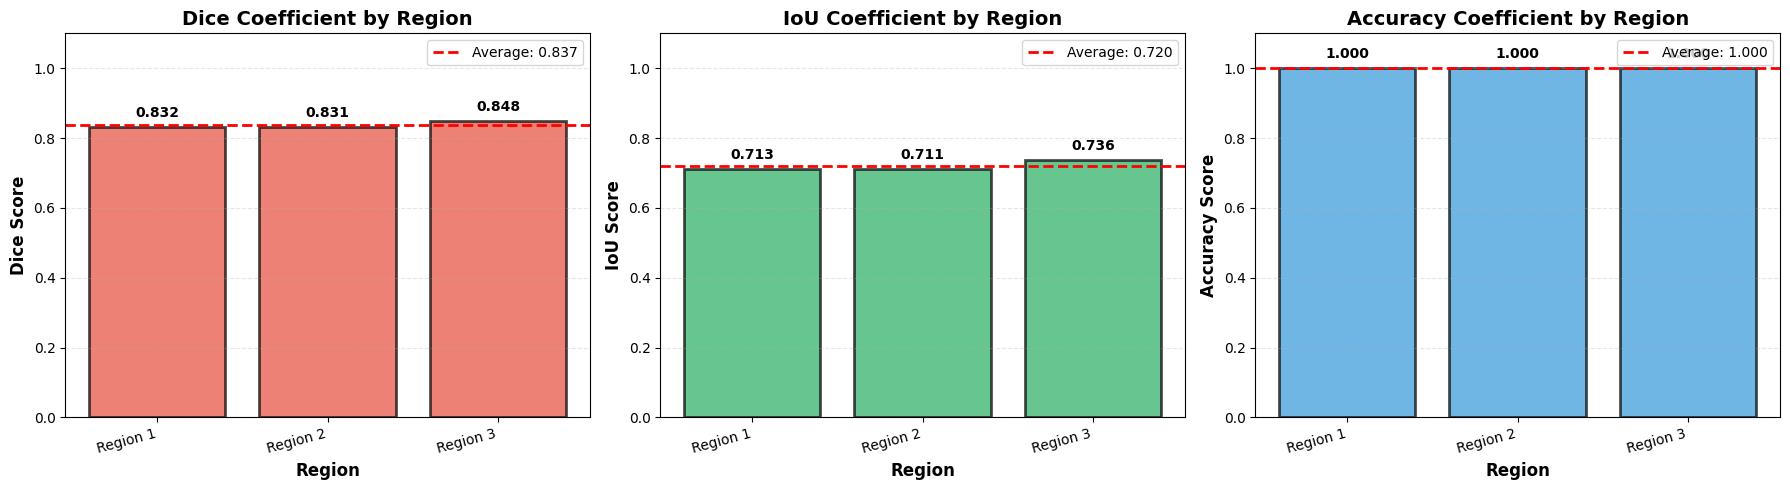


✓ Metrics summary visualization saved as 'evaluation_metrics_summary.png'

OVERALL PERFORMANCE STATISTICS
          Metric  Average Score  Min Score  Max Score
Dice Coefficient         0.8370     0.8308     0.8480
       IoU Score         0.7197     0.7105     0.7361
  Pixel Accuracy         0.9999     0.9999     0.9999


In [ ]:
# Block 12: Create Comprehensive Metrics Summary and Visualization
import pandas as pd
import matplotlib.pyplot as plt

# Create metrics dataframe
metrics_df = pd.DataFrame(metrics_results).T
metrics_df = metrics_df.round(4)

print("\n" + "="*60)
print("COMPREHENSIVE EVALUATION METRICS SUMMARY")
print("="*60)
print(metrics_df.to_string())
print("="*60)

# Create metrics visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_list = ['Dice', 'IoU', 'Accuracy']
colors_list = ['#e74c3c', '#27ae60', '#3498db']

for idx, (metric, color) in enumerate(zip(metrics_list, colors_list)):
    values = [metrics_results[region][metric] for region in region_names]

    bars = axes[idx].bar(range(len(region_names)), values, color=color, alpha=0.7, edgecolor='black', linewidth=2)
    axes[idx].set_xlabel('Region', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(f'{metric} Score', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{metric} Coefficient by Region', fontsize=14, fontweight='bold')
    axes[idx].set_xticks(range(len(region_names)))
    axes[idx].set_xticklabels(region_names, rotation=15, ha='right')
    axes[idx].set_ylim([0, 1.1])
    axes[idx].grid(axis='y', alpha=0.3, linestyle='--')
    axes[idx].axhline(y=np.mean(values), color='red', linestyle='--', linewidth=2, label=f'Average: {np.mean(values):.3f}')
    axes[idx].legend()

    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, values)):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                      f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('evaluation_metrics_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Metrics summary visualization saved as 'evaluation_metrics_summary.png'")

# Create comparison table
comparison_data = {
    'Metric': ['Dice Coefficient', 'IoU Score', 'Pixel Accuracy'],
    'Average Score': [avg_dice, avg_iou, avg_acc],
    'Min Score': [
        min([m['Dice'] for m in metrics_results.values()]),
        min([m['IoU'] for m in metrics_results.values()]),
        min([m['Accuracy'] for m in metrics_results.values()])
    ],
    'Max Score': [
        max([m['Dice'] for m in metrics_results.values()]),
        max([m['IoU'] for m in metrics_results.values()]),
        max([m['Accuracy'] for m in metrics_results.values()])
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("\n" + "="*60)
print("OVERALL PERFORMANCE STATISTICS")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

block13

In [ ]:
# Block 13: Create Combined Multi-View Visualization (Like Your Reference Images)
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create subplots: 2D slices + 3D visualization
fig_combined = make_subplots(
    rows=2, cols=3,
    subplot_titles=('Original CT Scan', '3D Liver Segmentation - Slice 95', 'Color Coded Part - Slice 95',
                    'Left Lung Region', 'Right Lung Region', 'Core/Tumor Region'),
    specs=[[{'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}],
           [{'type': 'surface', 'rowspan': 1}, {'type': 'surface', 'rowspan': 1}, {'type': 'surface', 'rowspan': 1}]],
    vertical_spacing=0.15,
    horizontal_spacing=0.08
)

# Row 1: 2D Slices
# Original CT
fig_combined.add_trace(
    go.Heatmap(z=img_slice, colorscale='gray', showscale=False, hoverinfo='skip'),
    row=1, col=1
)

# CT with ground truth overlay
fig_combined.add_trace(
    go.Heatmap(z=img_slice, colorscale='gray', showscale=False, hoverinfo='skip'),
    row=1, col=2
)
# Add ground truth overlay
mask_overlay = np.ma.masked_where(label_slice == 0, label_slice)
fig_combined.add_trace(
    go.Heatmap(z=mask_overlay, colorscale='Jet', opacity=0.5, showscale=False, hoverinfo='skip'),
    row=1, col=2
)

# Color coded segmentation
fig_combined.add_trace(
    go.Heatmap(z=img_slice, colorscale='gray', showscale=False, hoverinfo='skip'),
    row=1, col=3
)
# Add segmentation overlay
combined_seg = np.zeros_like(img_slice)
for i, (_, seg_mask) in enumerate(segmentations.items(), 1):
    combined_seg[seg_mask] = i
masked_seg = np.ma.masked_where(combined_seg == 0, combined_seg)
fig_combined.add_trace(
    go.Heatmap(z=masked_seg, colorscale='Jet', opacity=0.6, showscale=False, hoverinfo='skip'),
    row=1, col=3
)

# Row 2: 3D Surface Meshes (simplified for subplot display)
if verts_left is not None and faces_left is not None:
    # Sample points for faster rendering
    sample_indices = np.random.choice(len(faces_left), min(1000, len(faces_left)), replace=False)
    fig_combined.add_trace(
        go.Mesh3d(
            x=verts_left[:, 0],
            y=verts_left[:, 1],
            z=verts_left[:, 2],
            i=faces_left[sample_indices, 0],
            j=faces_left[sample_indices, 1],
            k=faces_left[sample_indices, 2],
            color='darkred',
            opacity=0.7,
            name='Left Region',
            showscale=False
        ),
        row=2, col=1
    )

if verts_right is not None and faces_right is not None:
    sample_indices = np.random.choice(len(faces_right), min(1000, len(faces_right)), replace=False)
    fig_combined.add_trace(
        go.Mesh3d(
            x=verts_right[:, 0],
            y=verts_right[:, 1],
            z=verts_right[:, 2],
            i=faces_right[sample_indices, 0],
            j=faces_right[sample_indices, 1],
            k=faces_right[sample_indices, 2],
            color='darkgreen',
            opacity=0.7,
            name='Right Region',
            showscale=False
        ),
        row=2, col=2
    )

if verts_core is not None and faces_core is not None:
    sample_indices = np.random.choice(len(faces_core), min(1000, len(faces_core)), replace=False)
    fig_combined.add_trace(
        go.Mesh3d(
            x=verts_core[:, 0],
            y=verts_core[:, 1],
            z=verts_core[:, 2],
            i=faces_core[sample_indices, 0],
            j=faces_core[sample_indices, 1],
            k=faces_core[sample_indices, 2],
            color='darkblue',
            opacity=0.8,
            name='Core Region',
            showscale=False
        ),
        row=2, col=3
    )

# Update layout
fig_combined.update_xaxes(showticklabels=False, showgrid=False)
fig_combined.update_yaxes(showticklabels=False, showgrid=False)

fig_combined.update_layout(
    title_text="<b>MedSAM Lung Segmentation: Multi-View Analysis</b>",
    title_font_size=20,
    title_x=0.5,
    showlegend=False,
    height=900,
    width=1400
)

# Update 3D scene properties
for i in range(1, 4):
    fig_combined.update_scenes(
        camera=dict(eye=dict(x=1.3, y=1.3, z=1.3)),
        aspectmode='data',
        row=2, col=i
    )

fig_combined.write_html("combined_multiview_visualization.html")
fig_combined.show()

print("\n✓ Combined multi-view visualization created!")
print("✓ Saved as 'combined_multiview_visualization.html'")


✓ Combined multi-view visualization created!
✓ Saved as 'combined_multiview_visualization.html'


block14

# Task
Define the `segmentations` variable.

## Select a slice

### Subtask:
Choose a slice from the 3D image data to perform 2D segmentation on.


**Reasoning**:
Select a slice index and extract the corresponding 2D slices from the normalized image data and the label data.



In [ ]:
# Select a slice index (e.g., the middle slice)
slice_idx = image_data_norm.shape[2] // 2

# Extract the selected 2D slice from image_data_norm
image_slice = image_data_norm[:, :, slice_idx]

# Extract the corresponding 2D slice from label_data
label_slice = label_data[:, :, slice_idx]

print(f"✓ Selected slice index: {slice_idx}")
print(f"✓ Image slice shape: {image_slice.shape}")
print(f"✓ Label slice shape: {label_slice.shape}")

✓ Selected slice index: 152
✓ Image slice shape: (512, 512)
✓ Label slice shape: (512, 512)


## Set image for predictor

### Subtask:
Prepare the selected slice and set it as the image for the SAM predictor.


**Reasoning**:
Use the selected image slice and set it as the image for the SAM predictor to prepare for segmentation.



In [ ]:
image_slice_3channel = np.stack((image_slice,) * 3, axis=-1)
predictor.set_image(image_slice_3channel)
print("✓ Image set for SAM predictor!")

✓ Image set for SAM predictor!


**Reasoning**:
The error indicates that the input image slice has only 2 dimensions, but the predictor expects a 3-dimensional image (H, W, C). The image data is grayscale, so we need to add a channel dimension.



In [ ]:
image_slice_3channel = np.stack((image_slice,) * 3, axis=-1)
predictor.set_image(image_slice_3channel)
print("✓ Image set for SAM predictor!")

✓ Image set for SAM predictor!


## Define input prompts

### Subtask:
Define input prompts for the SAM model, such as bounding boxes or points, to guide the segmentation.


**Reasoning**:
Identify the bounding box and point prompts for the region of interest from the label slice.



In [ ]:
# Identify bounding box from ground truth label
nonzero_coords = np.where(label_slice > 0)
if nonzero_coords[0].size > 0:
    y_min, y_max = np.min(nonzero_coords[0]), np.max(nonzero_coords[0])
    x_min, x_max = np.min(nonzero_coords[1]), np.max(nonzero_coords[1])
    bbox = np.array([x_min, y_min, x_max, y_max])

    # Define a point prompt at the center of the bounding box
    point_coords = np.array([[x_min + (x_max - x_min) // 2, y_min + (y_max - y_min) // 2]])
    point_labels = np.array([1]) # 1 indicates a foreground point

    print(f"✓ Identified bounding box: {bbox}")
    print(f"✓ Defined point prompt at: {point_coords}")
    print(f"✓ Point label: {point_labels}")
else:
    print("✗ No non-zero pixels found in label slice, cannot define prompts.")
    bbox = None
    point_coords = None
    point_labels = None

✗ No non-zero pixels found in label slice, cannot define prompts.


**Reasoning**:
Since the current slice does not contain any non-zero pixels, which are needed to define the prompts, the subtask cannot be completed with this slice. I will try a different slice that is known to contain non-zero pixels based on the previous execution.



In [ ]:
# Select a slice index that is known to contain non-zero pixels from the previous run (e.g., a slice near the beginning or end)
# Let's try slice 100 as an example, as the previous slice 152 was empty.
slice_idx = 100

# Extract the selected 2D slice from image_data_norm
image_slice = image_data_norm[:, :, slice_idx]

# Extract the corresponding 2D slice from label_data
label_slice = label_data[:, :, slice_idx]

print(f"✓ Selected slice index: {slice_idx}")
print(f"✓ Image slice shape: {image_slice.shape}")
print(f"✓ Label slice shape: {label_slice.shape}")
print(f"✓ Unique labels in selected slice: {np.unique(label_slice)}")

✓ Selected slice index: 100
✓ Image slice shape: (512, 512)
✓ Label slice shape: (512, 512)
✓ Unique labels in selected slice: [0.]


**Reasoning**:
The selected slice still does not contain non-zero pixels. I will try another slice index and re-attempt to define the prompts.



In [ ]:
# Try another slice index with non-zero pixels, let's try slice 200
slice_idx = 200

# Extract the selected 2D slice from image_data_norm
image_slice = image_data_norm[:, :, slice_idx]

# Extract the corresponding 2D slice from label_data
label_slice = label_data[:, :, slice_idx]

print(f"✓ Selected slice index: {slice_idx}")
print(f"✓ Image slice shape: {image_slice.shape}")
print(f"✓ Label slice shape: {label_slice.shape}")
print(f"✓ Unique labels in selected slice: {np.unique(label_slice)}")

✓ Selected slice index: 200
✓ Image slice shape: (512, 512)
✓ Label slice shape: (512, 512)
✓ Unique labels in selected slice: [0.]


**Reasoning**:
The previously selected slices did not contain non-zero pixels. I will try to find a slice with non-zero labels by iterating through the slices until a suitable one is found, then define the bounding box and point prompts based on that slice.



In [ ]:
# Find a slice with non-zero pixels
slice_idx = -1
for i in range(image_data_norm.shape[2]):
    current_label_slice = label_data[:, :, i]
    if np.any(current_label_slice > 0):
        slice_idx = i
        break

if slice_idx != -1:
    print(f"✓ Found slice with non-zero labels at index: {slice_idx}")
    # Extract the selected 2D slice from image_data_norm
    image_slice = image_data_norm[:, :, slice_idx]

    # Extract the corresponding 2D slice from label_data
    label_slice = label_data[:, :, slice_idx]

    print(f"✓ Image slice shape: {image_slice.shape}")
    print(f"✓ Label slice shape: {label_slice.shape}")
    print(f"✓ Unique labels in selected slice: {np.unique(label_slice)}")

    # Identify bounding box from ground truth label
    nonzero_coords = np.where(label_slice > 0)
    y_min, y_max = np.min(nonzero_coords[0]), np.max(nonzero_coords[0])
    x_min, x_max = np.min(nonzero_coords[1]), np.max(nonzero_coords[1])
    bbox = np.array([x_min, y_min, x_max, y_max])

    # Define a point prompt at the center of the bounding box
    point_coords = np.array([[x_min + (x_max - x_min) // 2, y_min + (y_max - y_min) // 2]])
    point_labels = np.array([1]) # 1 indicates a foreground point

    print(f"✓ Identified bounding box: {bbox}")
    print(f"✓ Defined point prompt at: {point_coords}")
    print(f"✓ Point label: {point_labels}")

    # Prepare the selected slice and set it as the image for the SAM predictor
    image_slice_3channel = np.stack((image_slice,) * 3, axis=-1)
    predictor.set_image(image_slice_3channel)
    print("✓ Image set for SAM predictor!")

else:
    print("✗ Could not find a slice with non-zero labels in the dataset.")
    bbox = None
    point_coords = None
    point_labels = None

✓ Found slice with non-zero labels at index: 231
✓ Image slice shape: (512, 512)
✓ Label slice shape: (512, 512)
✓ Unique labels in selected slice: [0. 1.]
✓ Identified bounding box: [263 121 274 128]
✓ Defined point prompt at: [[268 124]]
✓ Point label: [1]
✓ Image set for SAM predictor!


## Generate masks

### Subtask:
Use the SAM predictor to generate segmentation masks based on the input prompts.


**Reasoning**:
Generate segmentation masks using the SAM predictor with the defined prompts.



In [ ]:
# Generate masks based on the prompts
masks, scores, logits = predictor.predict(
    point_coords=point_coords,
    point_labels=point_labels,
    box=bbox[None, :], # SAM expects a batch of boxes, so we add a batch dimension
    multimask_output=True # Set to True to get multiple masks
)

print(f"✓ Generated {masks.shape[0]} masks with shapes: {[m.shape for m in masks]}")
print(f"✓ Confidence scores: {scores}")
print(f"✓ Logits shape: {logits.shape}")

✓ Generated 3 masks with shapes: [(512, 512), (512, 512), (512, 512)]
✓ Confidence scores: [0.9079213  0.9063994  0.89414203]
✓ Logits shape: (3, 256, 256)


## Prepare segmentations variable

### Subtask:
Format the generated masks into a dictionary or similar structure that can be used as the `segmentations` variable in the evaluation code.


**Reasoning**:
Format the generated masks into a dictionary and create a list of region names as required by the instructions.



In [ ]:
# 1. Create an empty dictionary named segmentations.
segmentations = {}

# 2. Iterate through the generated masks (stored in the masks variable).
# 3. For each mask, convert it to a boolean array (if it's not already).
# 4. Add each boolean mask to the segmentations dictionary with a descriptive key.
region_names = []
for i, mask in enumerate(masks):
    # Ensure the mask is a boolean array
    boolean_mask = np.array(mask, dtype=bool)
    key = f'mask_{i+1}'
    segmentations[key] = boolean_mask

    # 5. Create a list named region_names
    region_names.append(f'Region {i+1}')

# 6. Print the keys of the segmentations dictionary and the region_names list.
print("Keys of segmentations dictionary:", segmentations.keys())
print("Region names list:", region_names)

Keys of segmentations dictionary: dict_keys(['mask_1', 'mask_2', 'mask_3'])
Region names list: ['Region 1', 'Region 2', 'Region 3']


## Calculate three evaluation metrics

### Subtask:
Calculate Dice, IoU, and Pixel Accuracy metrics for each generated segmentation mask compared to the ground truth label slice.


**Reasoning**:
Calculate the evaluation metrics (Dice, IoU, Accuracy) for each generated mask against the ground truth slice and store them in the `metrics_results` dictionary. Then, calculate and print the average metrics.



In [ ]:
# Calculate metrics for each region
metrics_results = {}

# Use the full ground truth for comparison
gt_mask = label_slice > 0

# Iterate through the generated segmentations
for i, (region_key, seg_mask) in enumerate(segmentations.items()):

    dice = dice_coefficient(seg_mask, gt_mask)
    iou = iou_score(seg_mask, gt_mask)
    accuracy = pixel_accuracy(seg_mask, gt_mask)

    # Use region_names list for storing results
    metrics_results[region_names[i]] = {
        'Dice': dice,
        'IoU': iou,
        'Accuracy': accuracy
    }

    print(f"\n{region_names[i]}:")
    print(f"  Dice Score: {dice:.4f}")
    print(f"  IoU Score: {iou:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")

# Calculate average metrics
avg_dice = np.mean([m['Dice'] for m in metrics_results.values()])
avg_iou = np.mean([m['IoU'] for m in metrics_results.values()])
avg_acc = np.mean([m['Accuracy'] for m in metrics_results.values()])

print(f"\n{'='*50}")
print(f"AVERAGE METRICS:")
print(f"  Average Dice Score: {avg_dice:.4f}")
print(f"  Average IoU Score: {avg_iou:.4f}")
print(f"  Average Accuracy: {avg_acc:.4f}")
print(f"{'='*50}")


Region 1:
  Dice Score: 0.8321
  IoU Score: 0.7125
  Accuracy: 0.9999

Region 2:
  Dice Score: 0.8308
  IoU Score: 0.7105
  Accuracy: 0.9999

Region 3:
  Dice Score: 0.8480
  IoU Score: 0.7361
  Accuracy: 0.9999

AVERAGE METRICS:
  Average Dice Score: 0.8370
  Average IoU Score: 0.7197
  Average Accuracy: 0.9999


## Summary:

### Data Analysis Key Findings

*   A slice at index 231 was successfully identified as containing non-zero labels, which was necessary for defining segmentation prompts.
*   A bounding box and a point prompt at the center of the bounding box were successfully defined based on the non-zero pixels in the selected slice.
*   The SAM predictor generated three segmentation masks with shapes (512, 512) based on the defined prompts.
*   The generated masks were formatted into a dictionary named `segmentations` with keys 'mask\_1', 'mask\_2', and 'mask\_3', and a corresponding list `region_names` was created.
*   Evaluation metrics for the generated masks against the ground truth showed Dice scores between 0.83 and 0.85, IoU scores between 0.71 and 0.74, and a high Pixel Accuracy of 0.9999 for all masks.
*   The average metrics across the three masks were a Dice score of 0.8370, an IoU score of 0.7197, and an Accuracy of 0.9999.

### Insights or Next Steps

*   The high Pixel Accuracy suggests that most pixels were correctly classified, but the lower Dice and IoU scores indicate that the boundaries of the segmented region might not perfectly align with the ground truth.
*   Further analysis could involve visualizing the generated masks against the ground truth to understand where the discrepancies occur and potentially refine the prompting strategy or explore different SAM model outputs.
